In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

patient_data_path = '/home/tstrebel/repos/umich-mads-capstone-project/assets/rsna-patient-details.csv'

In [2]:
df = pd.read_csv(patient_data_path)

df['age_group'] = pd.cut(df.patient_age, 
                                  [0, 1, 5, 12, 18, 44, 64, 79, np.inf], 
                                  labels=['Infant 1 year-old', 
                                          'preschool (2-5)', 
                                          'Child (6-12)', 
                                          'Adolescent (13-18)', 
                                          'Adult (19-44)', 
                                          'Middle age (45-64)', 
                                          'Aged (65-79)', 'Aged 80+'])
df['view_position'] = df['view_position'].map({'AP':'Anterior/Posterior', 'PA':'Posterior/Anterior'})

df.head()

,index,patient_id,patient_age,patient_sex,view_position,class,target,split,rsna_baseline_proba,rsna_densenet_proba,age_group
0,0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,51,F,Posterior/Anterior,No Lung Opacity / Not Normal,0,train,0.199968,0.272411,Middle age (45-64)
1,1,000924cf-0f8d-42bd-9158-1af53881a557,19,F,Anterior/Posterior,Normal,0,train,0.156917,0.031587,Adult (19-44)
2,2,000db696-cf54-4385-b10b-6b16fbb3f985,25,F,Anterior/Posterior,Lung Opacity,1,train,0.688685,0.698994,Adult (19-44)
3,3,000fe35a-2649-43d4-b027-e67796d412e0,40,M,Anterior/Posterior,Lung Opacity,1,train,0.943956,0.984925,Adult (19-44)
4,4,001031d9-f904-4a23-b3e5-2c088acd19c6,57,M,Posterior/Anterior,Lung Opacity,1,train,0.374111,0.407364,Middle age (45-64)


In [17]:
def get_y_test_y_score(proba_col_name=None) -> None:
    if not proba_col_name:
        raise Exception('Must specify probal_col_name!')
    df_test = df[df['split']=='test']
    return df_test.target, df_test[proba_col_name]

def print_metrics(ytest, y_score, model_name):
    # Threshold tuning
    precision, recall, thresh = metrics.precision_recall_curve(y_test, y_score)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    y_pred = (y_score >= thresh[ix]).astype(int)

    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    roc_auc = metrics.roc_auc_score(y_test, y_score)
    avg_precision = metrics.average_precision_score(y_test, y_score)
    
    print('Model:\t\t{}'.format(model_name))
    print('Best Threshold:\t\t{:.2f}'.format(thresh[ix]))
    print('Precision:\t\t{:.2f}'.format(precision))
    print('Recall:\t\t\t{:.2f}'.format(recall))
    print('F1:\t\t\t{:.2f}'.format(f1))
    print('ROC AUC:\t\t{:.2f}'.format(roc_auc))
    print('Average Precision:\t{:.2f}'.format(avg_precision))

In [18]:
y_test, y_score = get_y_test_y_score(proba_col_name='rsna_baseline_proba')
print_metrics(y_test, y_score, model_name='Path A')

Model:		Path A
Best Threshold:		0.35
Precision:		0.61
Recall:			0.66
F1:			0.63
ROC AUC:		0.86
Average Precision:	0.66


In [19]:
y_test, y_score = get_y_test_y_score(proba_col_name='rsna_densenet_proba')
print_metrics(y_test, y_score, model_name='Path B')

Model:		Path B
Best Threshold:		0.41
Precision:		0.62
Recall:			0.69
F1:			0.65
ROC AUC:		0.88
Average Precision:	0.70


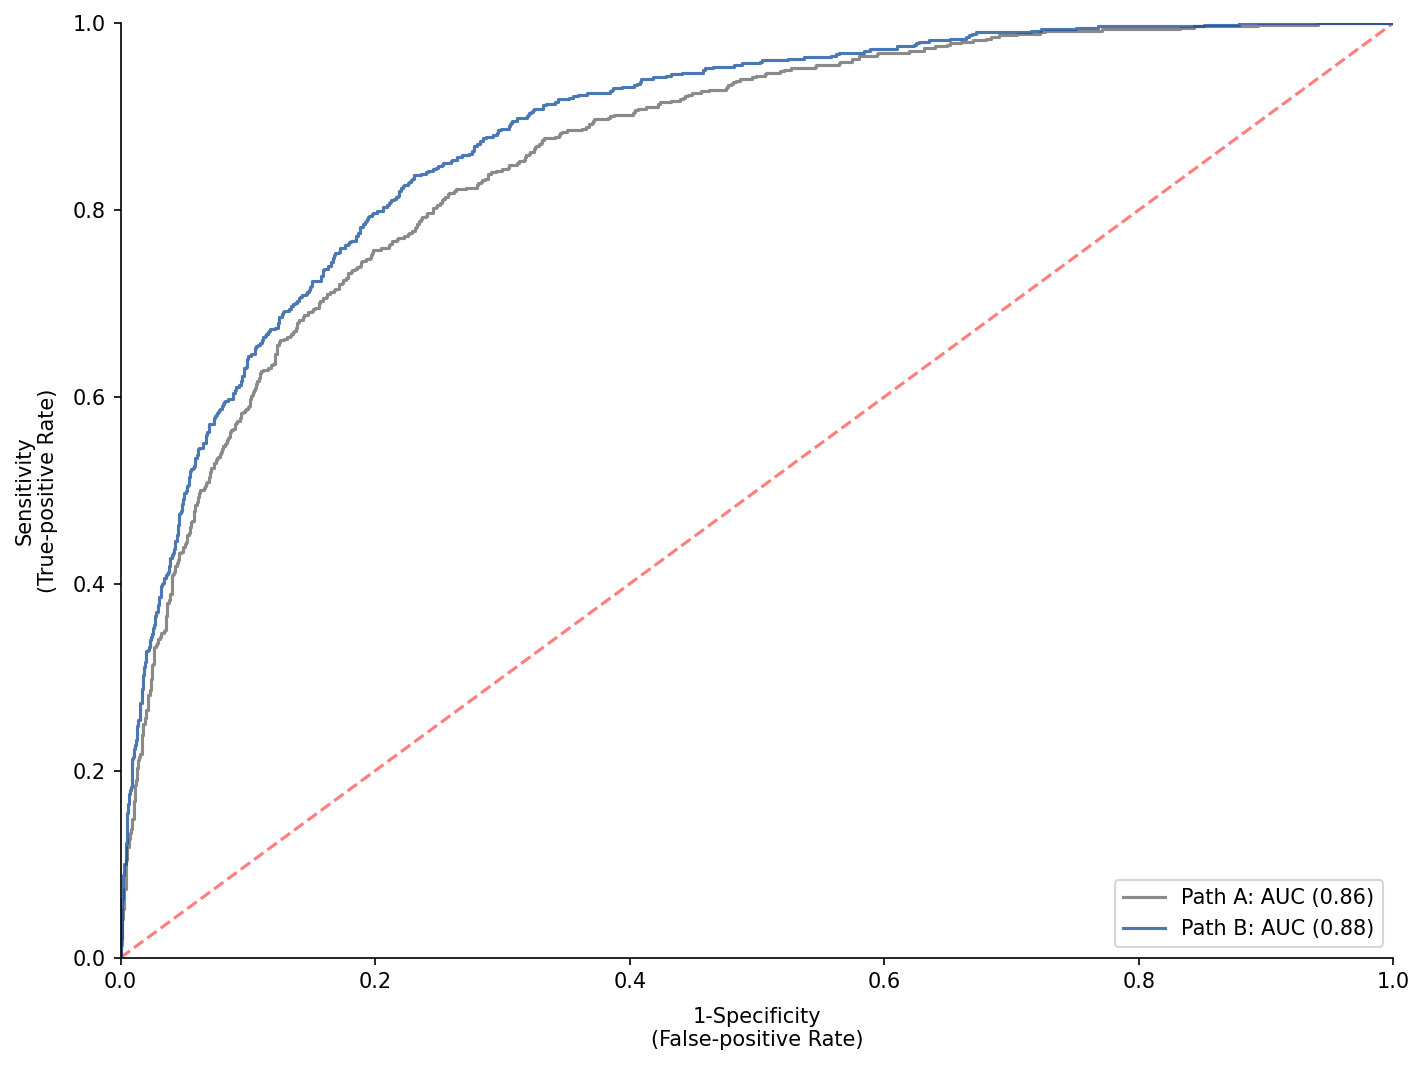

In [14]:
def plot_aurocs(save_path:str=None) -> None:
    dpi = 150
    figsize = np.array([6.4, 4.8]) * (dpi/100)
    fig = plt.figure(dpi=150, figsize=figsize)
    ax = fig.gca()
    
    ax.plot([0, 1], [0, 1], '--', color='red', alpha=.5)
    
    for label, col, color in [('Path A:', 'rsna_baseline_proba', '#636362'), 
                              ('Path B:', 'rsna_densenet_proba', '#0f4999'),
                              # ('Path C)', '', '#89c499')
                             ]:
        y_test, y_score = get_y_test_y_score(proba_col_name=col)
        tpr, fpr, _ = metrics.roc_curve(y_test, y_score)
        roc_auc = metrics.roc_auc_score(y_test, y_score)
        ax.plot(tpr, fpr, alpha=.75, color=color, label='{} AUC ({:.2f})'.format(label, roc_auc))
        
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='lower right')
    ax.set_xlabel('1-Specificity\n(False-positive Rate)', labelpad=7)
    ax.set_ylabel('Sensitivity\n(True-positive Rate)', labelpad=7)
    fig.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='png')
        
    plt.show()
    
plot_aurocs('/home/tstrebel/repos/umich-mads-capstone-project/figures/rsna-aurocs.png')

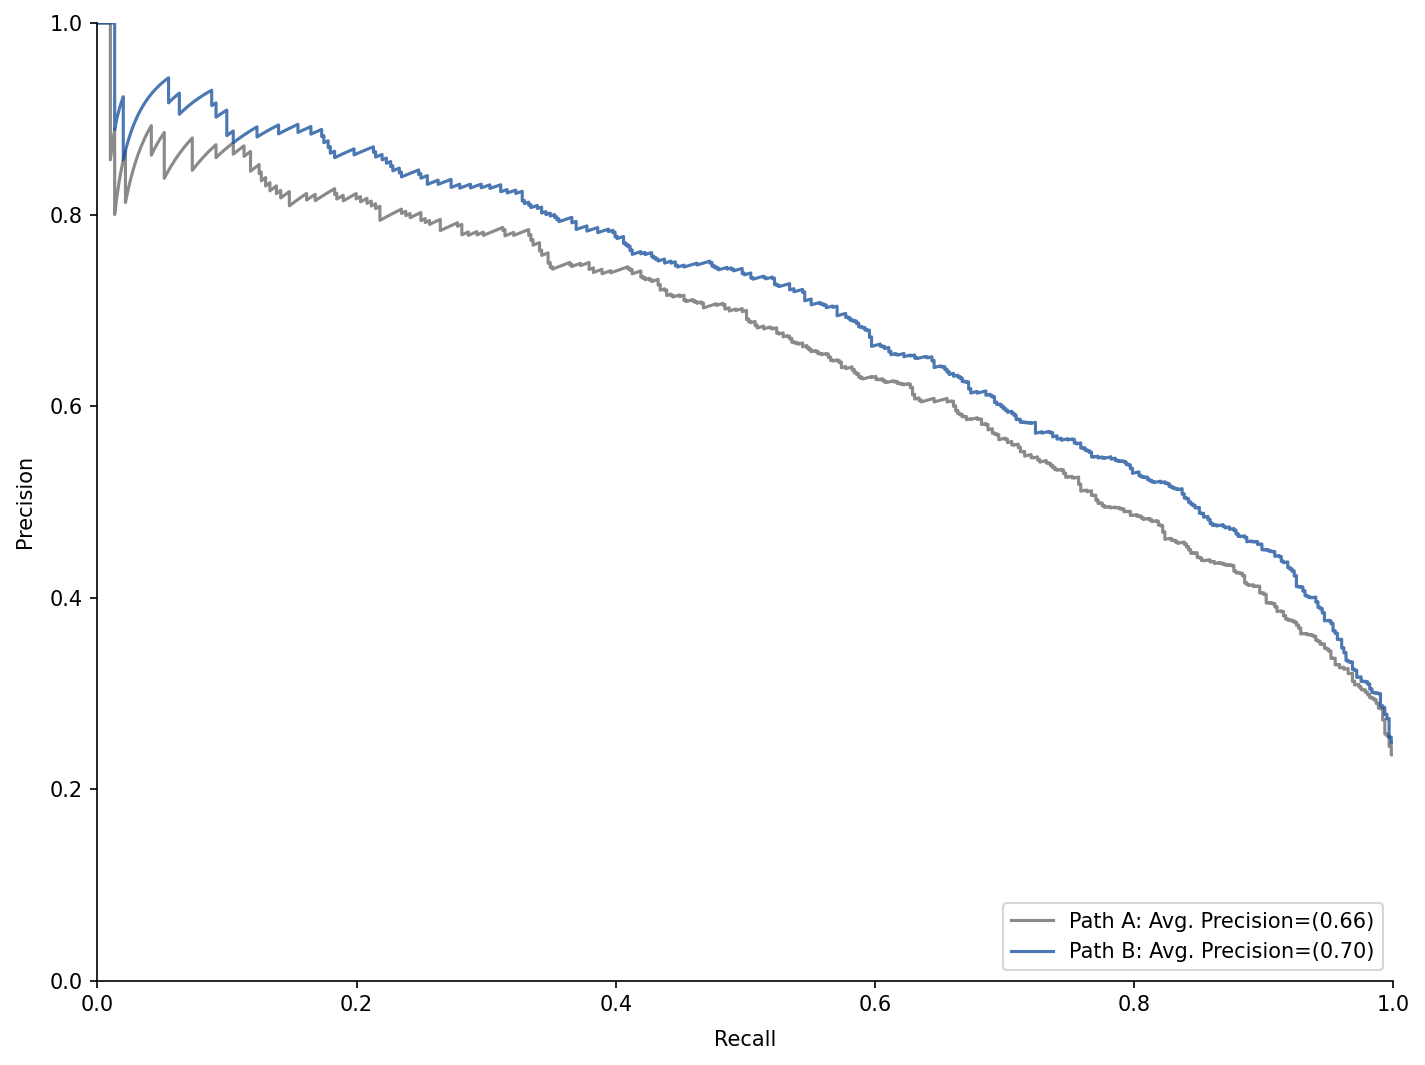

In [13]:
def plot_auprcs(save_path:str=None) -> None:
    dpi = 150
    figsize = np.array([6.4, 4.8]) * (dpi/100)
    fig = plt.figure(dpi=150, figsize=figsize)
    ax = fig.gca()
    
    for label, col, color in [('Path A:', 'rsna_baseline_proba', '#636362'), 
                              ('Path B:', 'rsna_densenet_proba', '#0f4999'),
                              # ('Path C)', '', '#89c499')
                             ]:
        y_test, y_score = get_y_test_y_score(proba_col_name=col)
        precision, recall, _ = metrics.precision_recall_curve(y_test, y_score)
        ap = metrics.average_precision_score(y_test, y_score)
        ax.plot(recall, precision, alpha=.75, color=color, label='{} Avg. Precision=({:.2f})'.format(label, ap))
        
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='lower right')
    ax.set_xlabel('Recall', labelpad=7)
    ax.set_ylabel('Precision', labelpad=7)
    fig.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='png')
        
    plt.show()
    
plot_auprcs('/home/tstrebel/repos/umich-mads-capstone-project/figures/rsna-auprcs.png')